# GDF5 Qin joint stem cells
### Code adapted from LI-21 TianLi code from Patrick

## scRNAseq annotation

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import scanpy as sc
import scipy as spy
import numpy as np
import math

#import loompy
import time
#import pySingleCellNet as pySCN
#import scvelo as scv
#import gseapy as gp
import matplotlib.pyplot as plt
#from gseapy.plot import barplot, dotplot, gseaplot
#import cellrank as cr
import leidenalg 

import os
os.getcwd()
wd = "/Users/knoller/Downloads/"
os.chdir(wd)
wd

'/Users/knoller/Downloads/'

In [2]:
adata = sc.read_h5ad("adJointDev_ALL_032322v2.h5ad")
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata.raw = adata

In [3]:
np.quantile(adata.X.todense(), q=[0,0.5,1])

array([   0.,    0., 5345.])

In [4]:
# Look at metadata
adata.obs['timepoint'].value_counts()

e13.5    4188
e12.5    2906
e17.5    2267
e14.5    1732
e15.5    1003
Name: timepoint, dtype: int64

In [5]:
adata.obs['topLevel'].value_counts() #same as batch layer

GLE        8630
non-GLE    3466
Name: topLevel, dtype: int64

In [6]:
adata.obs['level1'].value_counts()

SC3            3521
SC1            2686
myocyte        1128
SC2            1122
dermis          964
5 (stro)        633
2               354
blood           286
3               251
4               209
9 (divi)        141
6 (stro)        134
8 (prog)        123
1 (chon)         90
ncc              78
2 (liga)         54
6                52
7 (prog)         51
3 (line)         49
7                48
4 (synfib)       26
8                25
endothelial      23
0                22
melanocyte       15
erythro           6
5                 5
Name: level1, dtype: int64

In [7]:
adata.obs['level2'].value_counts()

SC3_A          2451
SC1_A          1791
myocyte        1128
SC3_B          1070
dermis          964
SC1_B           895
5 (stro)        633
SC2_A           627
SC2_B           495
2               354
blood           286
3               251
4               209
9 (divi)        141
6 (stro)        134
8 (prog)        123
1 (chon)         90
ncc              78
2 (liga)         54
6                52
7 (prog)         51
3 (line)         49
7                48
4 (synfib)       26
8                25
endothelial      23
0                22
melanocyte       15
erythro           6
5                 5
Name: level2, dtype: int64

In [8]:
adata.obs['level3'].value_counts()

SC3_A1         1568
myocyte        1128
SC1_A1         1018
dermis          964
SC3_B1          920
5 (stro)        633
SC1_A4          445
SC3_A2          388
2               354
SC1_A2          292
blood           286
SC3_A3          274
SC1_B5          261
3               251
SC3_A4          221
SC2_B1          221
SC1_B4          215
4               209
SC1_B3          188
SC2_A1          179
SC2_A2          162
9 (divi)        141
6 (stro)        134
SC1_B1          130
8 (prog)        123
SC2_A3          116
SC1_B2          101
SC2_B2           94
1 (chon)         90
SC2_B3           88
ncc              78
SC2_A4           75
SC3_B2           66
SC2_A5           60
SC2_B4           54
2 (liga)         54
6                52
7 (prog)         51
3 (line)         49
7                48
SC3_B3           43
SC3_B4           41
SC2_B5           38
SC1_A3           36
SC2_A6           35
4 (synfib)       26
8                25
endothelial      23
0                22
melanocyte       15


In [9]:
adata.obs['ann1'].value_counts()

joint          6273
nan            1301
myocyte        1128
cycling        1056
dermis          964
blood           286
ncc              78
endothelial      23
melanocyte       15
erythro           6
Name: ann1, dtype: int64

In [10]:
adata

AnnData object with n_obs × n_vars = 12096 × 31065
    obs: 'timepoint', 'ann1', 'level1', 'level2', 'level3', 'topLevel', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [11]:
# Cell cycle 
s_genes = [x.strip() for x in open('s_genes_mouse.txt')]
g2m_genes = [x.strip() for x in open('g2m_genes_mouse.txt')]

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
cell_cycle_genes = s_genes + g2m_genes

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['phase'] = adata.obs['phase'].copy()
adata.obs['S_score'] = adata.obs['S_score'].copy()
adata.obs['G2M_score'] = adata.obs['G2M_score'].copy()

In [12]:
#Filter genes and by total_counts
malat1 = adata.var_names.str.startswith('Malat1')
mito_genes = adata.var_names.str.startswith('mt-')
ribo_genes = adata.var_names.str.startswith(("Rpl","Rps"))
print(adata.var_names[mito_genes])

Index(['mt-Nd6', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6',
       'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Cytb'],
      dtype='object')


In [13]:
remove = np.add(mito_genes, malat1)
len(remove[remove==True])

remove = np.add(remove, ribo_genes)
len(remove[remove==True])

keep = np.invert(remove)
len(keep[keep==True])

adata = adata[:,keep]
print(adata.n_obs, adata.n_vars)

#thresh = np.percentile(adata.obs['total_counts'],97)
#print(thresh)
#adata = adata[adata.obs['total_counts'] < thresh, :]
#adata

12096 30946


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Prep for run_stemFinder: log normalize and scale, compute HVG, run PCA, compute K and neighbors, load marker genes

In [15]:
# Retrieve S and G2M cell cycle genes (Regev lab)

s_genes = [x.strip() for x in open('s_genes_mouse.txt')]
g2m_genes = [x.strip() for x in open('g2m_genes_mouse.txt')]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

cell_cycle_genes = s_genes + g2m_genes
print(cell_cycle_genes)

['Rrm2', 'Mcm4', 'Msh2', 'Exo1', 'Uhrf1', 'Chaf1b', 'Gmnn', 'Mcm2', 'Cdc45', 'Fen1', 'Slbp', 'Dscc1', 'Ubr7', 'Hells', 'Cdc6', 'Rad51ap1', 'Prim1', 'Blm', 'Nasp', 'Rpa2', 'Mcm5', 'Usp1', 'Tipin', 'Dtl', 'Cdca7', 'Pola1', 'Wdr76', 'Gins2', 'Ung', 'Tyms', 'Clspn', 'Mcm6', 'Rad51', 'Ccne2', 'Casp8ap2', 'Rfc2', 'Rrm1', 'Brip1', 'Pcna', 'E2f8', 'Cbx5', 'Gtse1', 'Dlgap5', 'Smc4', 'Cdc25c', 'Ctcf', 'Kif20b', 'Cdca2', 'Cdca3', 'Hmgb2', 'G2e3', 'Anp32e', 'Tacc3', 'Ttk', 'Cks2', 'Top2a', 'Gas2l3', 'Cdk1', 'Ncapd2', 'Ckap2', 'Kif2c', 'Ndc80', 'Anln', 'Cenpf', 'Kif23', 'Hmmr', 'Cdc20', 'Rangap1', 'Aurkb', 'Lbr', 'Ect2', 'Psrc1', 'Cdca8', 'Hjurp', 'Ccnb2', 'Birc5', 'Cenpe', 'Nek2', 'Tpx2', 'Kif11', 'Cenpa', 'Cks1b', 'E2f8', 'Aurka', 'Nuf2', 'Mki67', 'Bub1', 'Ckap5', 'Tubb4b', 'Ube2c', 'Ckap2l', 'Nusap1']


In [16]:
#Filter by min_cells, normalize, log transform
adM1Norm = adata.copy()
sc.pp.filter_genes(adM1Norm, min_cells=5)

sc.pp.highly_variable_genes(adM1Norm, flavor = 'seurat_v3', n_top_genes = 2500) #need to do before normalization if using seurat v3
hvg = adM1Norm.var_names[adM1Norm.var['highly_variable']]
print(len(hvg))

sc.pp.normalize_per_cell(adM1Norm, counts_per_cell_after=1e4)
sc.pp.log1p(adM1Norm)

#sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=4, min_disp=0.25) #if using flavor = 'seurat' from 2015 paper, compute HVG after normalization + log transform

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


2500


In [17]:
np.quantile(adM1Norm.X.todense(), q=[0,0.5,1])

array([0.        , 0.        , 8.39534187])

In [18]:
print(adM1Norm.var['highly_variable'])

Xkr4             False
Sox17             True
Mrpl15           False
Rgs20            False
4732440D04Rik    False
                 ...  
Ddx3y            False
Kdm5d            False
Eif2s3y          False
Gm29650          False
Gm47283           True
Name: highly_variable, Length: 17331, dtype: bool


In [19]:
#Remove any cell cycle genes from HVG
adM1Norm.var['highly_variable'][adM1Norm.var['highly_variable'].index.isin(cell_cycle_genes)] = False
hvg_nocc = adM1Norm.var_names[adM1Norm.var['highly_variable']]
print(len(hvg_nocc))

2458


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


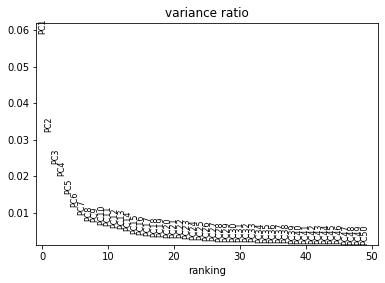

In [20]:
#Scale and PCA

adM1Norm.raw = adM1Norm #normalized, log transformed data

sc.pp.scale(adM1Norm, max_value=10) 
sc.tl.pca(adM1Norm, n_comps=50)
sc.pl.pca_variance_ratio(adM1Norm, 50)

In [21]:
#Nearest neighbors 

npcs = 25
k = round(math.sqrt(len(adM1Norm.obs)))
print(k)
sc.pp.neighbors(adM1Norm, n_neighbors=k, n_pcs=npcs, knn = True)


#conn = pd.DataFrame(adM1Norm.obsp['connectivities'].todense())
dist = pd.DataFrame(adM1Norm.obsp['distances'].todense())

110


In [22]:
# Format expDat and marker gene list inputs 

    # Subset anndata for only cell cycle genes
markers_bin = adata.var_names.isin(cell_cycle_genes)
adata_sub = adata[:,markers_bin]

 ##expDat: scaled expression data subsetted for only cell cycle genes, converted to pandas data frame
query = adata_sub.X
#expDat = pd.DataFrame(query) #for converted Seurat object
expDat = pd.DataFrame(query.todense()) #this works with anndata objects where query is sparse matrix, not with converted Seurat
expDat.index = adata_sub.obs_names
expDat.columns = adata_sub.var_names
print(expDat.shape)

    ##markers: list of cell cycle genes
markers = cell_cycle_genes 

(12096, 91)


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
#Set nearest neighbors matrix as distance matrix, converted to pd data frame
    ##NOTE: unlike Seurat, Scanpy does NOT list the query cell as connected to itself

nn = dist
nn.columns = adata_sub.obs_names
nn.index = adata_sub.obs_names

In [24]:
# Run stemFinder on distance matrix (gives fixed # neighbors per cell)
    # Same code as for connectivities matrix above
    
    
cell = list(nn.columns)
gini_index_agg = [] #empty list

for c in cell:
    neigh = (nn.iloc[nn.index == c,:].T)[(nn.iloc[nn.index == c,:].T).values > 0].index #list of neighbor names + cell name itself (len = k)
    k_c = len(neigh) #number of neighbors chosen for cell c by Scanpy
    exp = expDat.loc[(neigh | [c]),:] > 0 #binarize scaled expression matrix
    exp_match = exp == exp.loc[c] #boolean df - does gene expression pattern of neighbor cell match that of cell c?
    n_match = exp_match.T.sum() - 1 #num cells with matching expression patterns to cell c per gene
    p_g = n_match/(k_c)
    gini_g = p_g * (1 - p_g) 
    gini_index_agg.append(gini_g.sum())

#Make data frame containing all scores
invert = list((1 - (gini_index_agg)/max(gini_index_agg)))
comp = [x / len(markers) for x in gini_index_agg]

gini_agg = pd.DataFrame({'barcodes': cell, 'stemFinder': gini_index_agg, 'stemFinder_invert': invert, 'stemFinder_comp': comp})
gini_agg.index = cell
gini_agg

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/knoller/.pyenv/versio

barcodes  \
qb_E12-5_gdf:AAACCTGAGGCGTACAx-0-0-0  qb_E12-5_gdf:AAACCTGAGGCGTACAx-0-0-0   
qb_E12-5_gdf:AAACCTGCACTGCCAGx-0-0-0  qb_E12-5_gdf:AAACCTGCACTGCCAGx-0-0-0   
qb_E12-5_gdf:AAACCTGGTGAGTGACx-0-0-0  qb_E12-5_gdf:AAACCTGGTGAGTGACx-0-0-0   
qb_E12-5_gdf:AAACCTGGTTGCCTCTx-0-0-0  qb_E12-5_gdf:AAACCTGGTTGCCTCTx-0-0-0   
qb_E12-5_gdf:AAACCTGTCGAGAACGx-0-0-0  qb_E12-5_gdf:AAACCTGTCGAGAACGx-0-0-0   
...                                                                    ...   
qb_E17-5_gdf:TTGCGTCGTGTGGTTTx-1-1      qb_E17-5_gdf:TTGCGTCGTGTGGTTTx-1-1   
qb_E17-5_gdf:TTTGTCACATCCCACTx-1-1      qb_E17-5_gdf:TTTGTCACATCCCACTx-1-1   
qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1      qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1   
qb_E17-5_gdf:TTTGGTTTCGACGGAAx-1-1      qb_E17-5_gdf:TTTGGTTTCGACGGAAx-1-1   
qb_E17-5_gdf:TTGGCAAAGTGGGCTAx-1-1      qb_E17-5_gdf:TTGGCAAAGTGGGCTAx-1-1   

                                      stemFinder  stemFinder_invert  \
qb_E12-5_gdf:AAACCTGAGGCGTACAx-0-0-0   24.611565           0.099185   
qb_E12-5_gdf:AAACCTGCACTGCCAGx-0-0-0   26.967595           0.012951   
qb_E12-5_gdf:AAACCTGGTGAGTGACx-0-0-0   22.314452           0.183262   
qb_E12-5_gdf:AAACCTGGTTGCCTCTx-0-0-0   27.212524           0.003986   
qb_E12-5_gdf:AAACCTGTCGAGAACGx-0-0-0   25.062032           0.082697   
...                                          ...                ...   
qb_E17-5_gdf:TTGCGTCGTGTGGTTTx-1-1     20.443397           0.251745   
qb_E17-5_gdf:TTTGTCACATCCCACTx-1-1     17.257975           0.368336   
qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1     22.963050           0.159523   
qb_E17-5_gdf:TTTGGTTTCGACGGAAx-1-1     26.023230           0.047516   
qb_E17-5_gdf:TTGGCAAAGTGGGCTAx-1-1     17.775608           0.349390   

                                      stemFinder_comp  
qb_E12-5_gdf:AAACCTGAGGCGTACAx-0-0-0         0.267517  
qb_E12-5_gdf:AAACCTGCACTGCCAGx-0-0-0         0.293126  
qb_E12-5_gdf:AAACCTGGTGAGTGACx-0-0-0         0.242548  
qb_E12-5_gdf:AAACCTGGTTGCCTCTx-0-0-0         0.295788  
qb_E12-5_gdf:AAACCTGTCGAGAACGx-0-0-0         0.272413  
...                                               ...  
qb_E17-5_gdf:TTGCGTCGTGTGGTTTx-1-1           0.222211  
qb_E17-5_gdf:TTTGTCACATCCCACTx-1-1           0.187587  
qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1           0.249598  
qb_E17-5_gdf:TTTGGTTTCGACGGAAx-1-1           0.282861  
qb_E17-5_gdf:TTGGCAAAGTGGGCTAx-1-1           0.193213  

[12096 rows x 4 columns]

In [25]:
adM1Norm.obs['stemFinder_scanpy_dist'] = gini_agg['stemFinder']
adM1Norm.obs['stemFinder_invert_scanpy_dist'] = gini_agg['stemFinder_invert']
adM1Norm.obs['stemFinder_comp_scanpy_dist'] = gini_agg['stemFinder_comp']

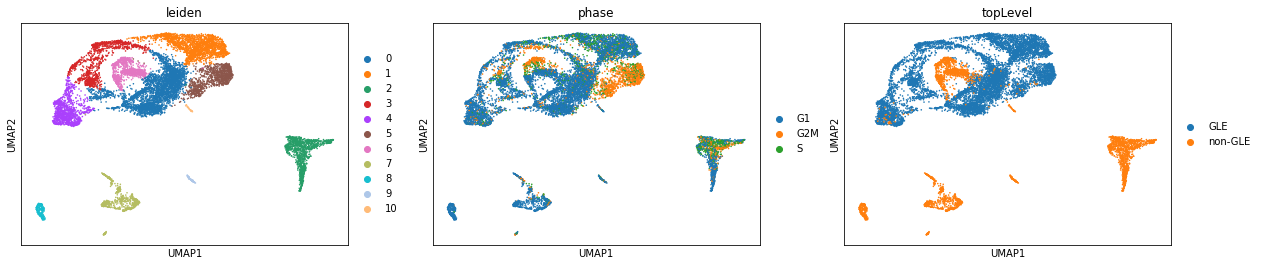

In [84]:
#Clustering
sc.tl.umap(adM1Norm, .25)
sc.tl.leiden(adM1Norm,.25)
sc.pl.umap(adM1Norm, color=["leiden", "phase","topLevel"])

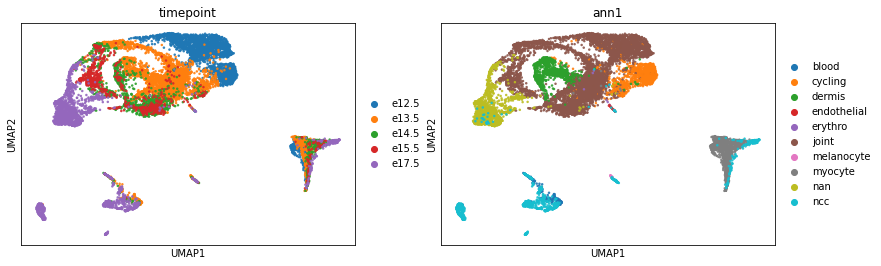

In [27]:
sc.pl.umap(adM1Norm, color = ["timepoint","ann1"], alpha=.9, s=25)# , legend_loc='on data', cmap='OrRd', ncols=4)

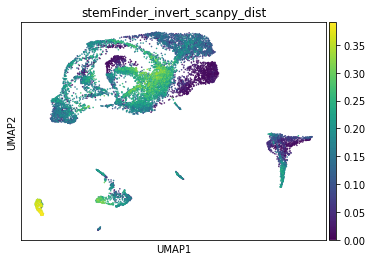

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


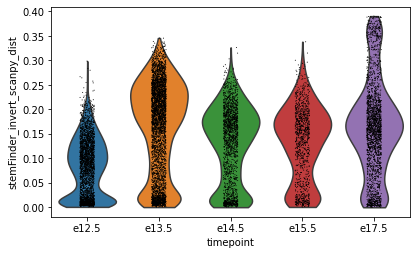

In [28]:
sc.pl.umap(adM1Norm, color = ["stemFinder_invert_scanpy_dist"], alpha=.9, s=10)# , legend_loc='on data', cmap='OrRd', ncols=4)
sc.pl.violin(adM1Norm, ['stemFinder_invert_scanpy_dist'], groupby = 'timepoint')

In [34]:
# Save adata with stemFinder results, Leiden clusters for all cells
adM1Norm.write_h5ad("e12to17_gdf5_results_011723.h5ad")

## Isolate myocytes, E12-17
### Leiden cluster 2

In [36]:
# Subset adata

myo_bars = adM1Norm[adM1Norm.obs['leiden'] == '2',:].obs_names
adMyo = adata[myo_bars,:].copy()
adMyo

AnnData object with n_obs × n_vars = 1302 × 30946
    obs: 'timepoint', 'ann1', 'level1', 'level2', 'level3', 'topLevel', 'batch', 'S_score', 'G2M_score', 'phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2500
2429


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


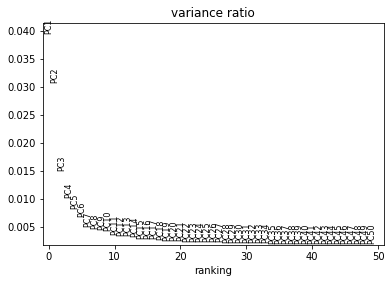

36


In [37]:
#Repeat below steps:
    #Min_cells filtering
    #Normalization, log transformation
    #HVG
    #Scale, PCA

sc.pp.filter_genes(adMyo, min_cells=5)

#HVG
sc.pp.highly_variable_genes(adMyo, flavor = 'seurat_v3', n_top_genes = 2500) #need to do before normalization if using seurat v3
hvg = adMyo.var_names[adMyo.var['highly_variable']]
print(len(hvg))
sc.pp.normalize_per_cell(adMyo, counts_per_cell_after=1e4)
sc.pp.log1p(adMyo)
#sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=4, min_disp=0.25) #if using flavor = 'seurat' from 2015 paper, compute HVG after normalization + log transform

#Remove any cell cycle genes from HVG
adMyo.var['highly_variable'][adMyo.var['highly_variable'].index.isin(cell_cycle_genes)] = False
hvg_nocc = adMyo.var_names[adMyo.var['highly_variable']]
print(len(hvg_nocc))

#Scale and PCA
sc.pp.scale(adMyo, max_value=10) 
sc.tl.pca(adMyo, n_comps=50)
sc.pl.pca_variance_ratio(adMyo, 50)

#Nearest neighbors 
npcs = 25
k = round(math.sqrt(len(adMyo.obs)))
print(k)
sc.pp.neighbors(adMyo, n_neighbors=k, n_pcs=npcs, knn = True)
dist = pd.DataFrame(adMyo.obsp['distances'].todense())

In [70]:
# To run stemFinder, had to use the code from running it on an imported Seurat anndata file. Not sure why


    # Subset anndata for only cell cycle genes
markers_bin = adMyo.var_names.isin(cell_cycle_genes)
adata_sub = adMyo[:,markers_bin]

 ##expDat: scaled expression data subsetted for only cell cycle genes, converted to pandas data frame
query = adata_sub.X
expDat = pd.DataFrame(query) #for converted Seurat object

#expDat = pd.DataFrame(query.todense()) #this works with anndata objects where query is sparse matrix, not with converted Seurat
expDat.index = adata_sub.obs_names
expDat.columns = adata_sub.var_names
print(expDat.shape) #must be cells x genes

    ##markers: list of cell cycle genes
markers = cell_cycle_genes 

#Set nearest neighbors matrix as distance matrix, converted to pd data frame
    ##NOTE: unlike Seurat, Scanpy does NOT list the query cell as connected to itself

nn = dist
nn.columns = adata_sub.obs_names
nn.index = adata_sub.obs_names

# Run stemFinder on distance matrix (gives fixed # neighbors per cell)

cell = list(nn.columns)
gini_index_agg = [] #empty list

for c in cell:
    neigh = (nn.iloc[nn.index == c,:].T)[(nn.iloc[nn.index == c,:].T).values > 0].index #list of neighbor names + cell name itself (len = k)
    k_c = len(neigh) #number of neighbors chosen for cell c by Scanpy
    exp = expDat.loc[(neigh | [c]),:] > 0 #binarize scaled expression matrix
    exp_match = exp == exp.loc[c] #boolean df - does gene expression pattern of neighbor cell match that of cell c?
    n_match = exp_match.sum() - 1 #num cells with matching expression patterns to cell c per gene
        #### HAD TO CHANGE THIS FROM EXP_MATCH.T.SUM
    
    p_g = n_match/(k_c)
    gini_g = p_g * (1 - p_g) 
    gini_index_agg.append(gini_g.sum())

#Make data frame containing all scores
invert = list((1 - (gini_index_agg)/max(gini_index_agg)))
comp = [x / len(markers) for x in gini_index_agg]

gini_agg = pd.DataFrame({'barcodes': cell, 'stemFinder': gini_index_agg, 'stemFinder_invert': invert, 'stemFinder_comp': comp})
gini_agg.index = cell
gini_agg

(1302, 91)


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

barcodes  \
qb_E13-5_gdf:GCATGATGTAGAGCTGx-1-0-0  qb_E13-5_gdf:GCATGATGTAGAGCTGx-1-0-0   
qb_E13-5_gdf:TCGTACCGTATCTGCAx-1-0-0  qb_E13-5_gdf:TCGTACCGTATCTGCAx-1-0-0   
qb_E12-5_gdf:AAACGGGGTTCCACAAx-0-0-1  qb_E12-5_gdf:AAACGGGGTTCCACAAx-0-0-1   
qb_E12-5_gdf:AAATGCCCAAGGACTGx-0-0-1  qb_E12-5_gdf:AAATGCCCAAGGACTGx-0-0-1   
qb_E12-5_gdf:AACACGTCACGGTAGAx-0-0-1  qb_E12-5_gdf:AACACGTCACGGTAGAx-0-0-1   
...                                                                    ...   
qb_E17-5_gdf:TTCCCAGAGCCCAATTx-1-1      qb_E17-5_gdf:TTCCCAGAGCCCAATTx-1-1   
qb_E17-5_gdf:TTAGGCAGTACCGTATx-1-1      qb_E17-5_gdf:TTAGGCAGTACCGTATx-1-1   
qb_E17-5_gdf:TTTCCTCGTCGCGAAAx-1-1      qb_E17-5_gdf:TTTCCTCGTCGCGAAAx-1-1   
qb_E17-5_gdf:TTTGTCAGTCAACTGTx-1-1      qb_E17-5_gdf:TTTGTCAGTCAACTGTx-1-1   
qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1      qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1   

                                      stemFinder  stemFinder_invert  \
qb_E13-5_gdf:GCATGATGTAGAGCTGx-1-0-0    9.340408           0.479436   
qb_E13-5_gdf:TCGTACCGTATCTGCAx-1-0-0   11.418776           0.363603   
qb_E12-5_gdf:AAACGGGGTTCCACAAx-0-0-1   12.839184           0.284440   
qb_E12-5_gdf:AAATGCCCAAGGACTGx-0-0-1    5.616327           0.686988   
qb_E12-5_gdf:AACACGTCACGGTAGAx-0-0-1   12.613878           0.296997   
...                                          ...                ...   
qb_E17-5_gdf:TTCCCAGAGCCCAATTx-1-1     12.324898           0.313103   
qb_E17-5_gdf:TTAGGCAGTACCGTATx-1-1     11.678367           0.349136   
qb_E17-5_gdf:TTTCCTCGTCGCGAAAx-1-1     16.035918           0.106278   
qb_E17-5_gdf:TTTGTCAGTCAACTGTx-1-1     14.191020           0.209099   
qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1      8.935510           0.502002   

                                      stemFinder_comp  
qb_E13-5_gdf:GCATGATGTAGAGCTGx-1-0-0         0.101526  
qb_E13-5_gdf:TCGTACCGTATCTGCAx-1-0-0         0.124117  
qb_E12-5_gdf:AAACGGGGTTCCACAAx-0-0-1         0.139556  
qb_E12-5_gdf:AAATGCCCAAGGACTGx-0-0-1         0.061047  
qb_E12-5_gdf:AACACGTCACGGTAGAx-0-0-1         0.137107  
...                                               ...  
qb_E17-5_gdf:TTCCCAGAGCCCAATTx-1-1           0.133966  
qb_E17-5_gdf:TTAGGCAGTACCGTATx-1-1           0.126939  
qb_E17-5_gdf:TTTCCTCGTCGCGAAAx-1-1           0.174303  
qb_E17-5_gdf:TTTGTCAGTCAACTGTx-1-1           0.154250  
qb_E17-5_gdf:TTGGCAATCACAACGTx-1-1           0.097125  

[1302 rows x 4 columns]

In [71]:
adMyo.obs['stemFinder_scanpy_dist'] = gini_agg['stemFinder']
adMyo.obs['stemFinder_invert_scanpy_dist'] = gini_agg['stemFinder_invert']
adMyo.obs['stemFinder_comp_scanpy_dist'] = gini_agg['stemFinder_comp']

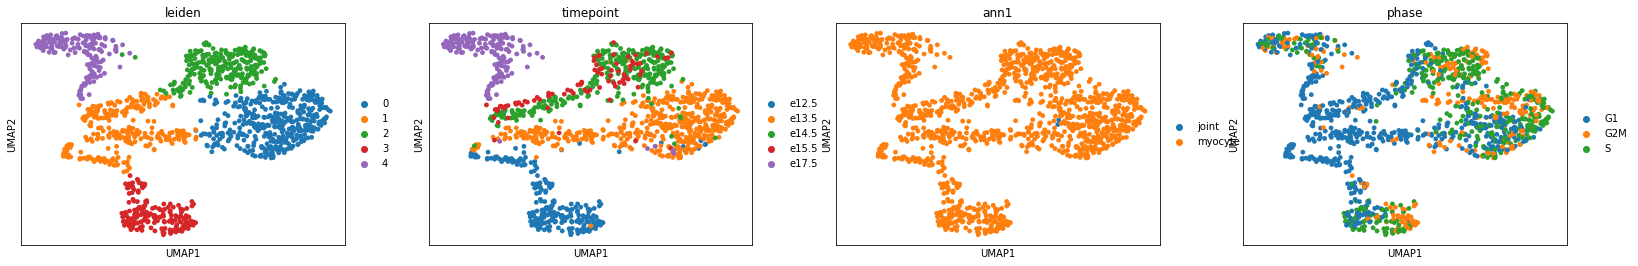

In [100]:
#Clustering
sc.tl.umap(adMyo, .25)
sc.tl.leiden(adMyo,.25)
sc.pl.umap(adMyo, color=["leiden", "timepoint", "ann1","phase"])

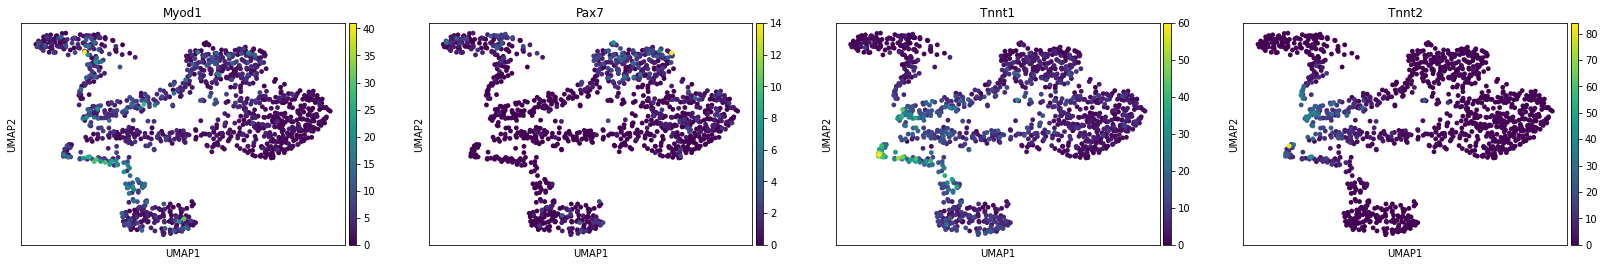

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


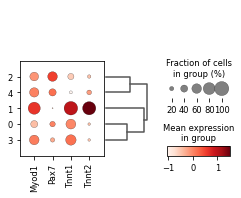

In [73]:
# Muscle marker expression
        #progenitor: Myod1, Pax7
        #cardiac / skeletal: Myod1, Tnnt1, Tnnt2 
myogenes =['Myod1','Pax7','Tnnt1','Tnnt2']
sc.pl.umap(adMyo, color = myogenes)
sc.tl.dendrogram(adMyo, groupby = 'leiden')
sc.pl.dotplot(adMyo, var_names=myogenes, groupby='leiden', use_raw=False,dendrogram=True)

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


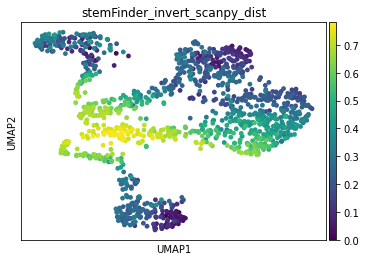

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


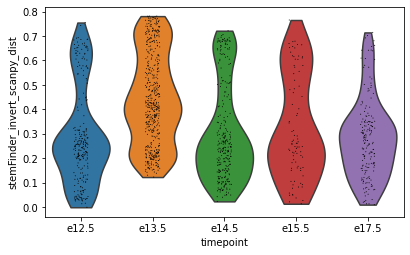

In [74]:
sc.pl.umap(adMyo, color = 'stemFinder_invert_scanpy_dist')
sc.pl.violin(adMyo, groupby = 'timepoint', keys = 'stemFinder_invert_scanpy_dist')

In [75]:
adMyo.write_h5ad("e12to17myocytes_sF_011823.h5ad")

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


## E17 joint lineage GDF5 cells 

In [87]:
# Subset adata for E17.5 cells only (says there are no joint lineage E17.5 cells?)

e17_bars = adM1Norm[adM1Norm.obs['timepoint'] == 'e17.5',:].obs_names
joint_bars = adM1Norm[adM1Norm.obs['topLevel'] == 'GLE',:].obs_names
bars = e17_bars.intersection(joint_bars)
print(len(bars))

adJoint = adata[bars,:].copy()
adJoint

1301


AnnData object with n_obs × n_vars = 1301 × 30946
    obs: 'timepoint', 'ann1', 'level1', 'level2', 'level3', 'topLevel', 'batch', 'S_score', 'G2M_score', 'phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

2500


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2431


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


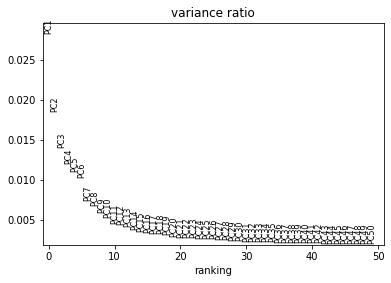

36


In [88]:
#Repeat below steps:
    #Min_cells filtering
    #Normalization, log transformation
    #HVG
    #Scale, PCA

sc.pp.filter_genes(adJoint, min_cells=5)

#HVG
sc.pp.highly_variable_genes(adJoint, flavor = 'seurat_v3', n_top_genes = 2500) #need to do before normalization if using seurat v3
hvg = adJoint.var_names[adJoint.var['highly_variable']]
print(len(hvg))
sc.pp.normalize_per_cell(adJoint, counts_per_cell_after=1e4)
sc.pp.log1p(adJoint)
#sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=4, min_disp=0.25) #if using flavor = 'seurat' from 2015 paper, compute HVG after normalization + log transform

#Remove any cell cycle genes from HVG
adJoint.var['highly_variable'][adJoint.var['highly_variable'].index.isin(cell_cycle_genes)] = False
hvg_nocc = adJoint.var_names[adJoint.var['highly_variable']]
print(len(hvg_nocc))

#Scale and PCA
sc.pp.scale(adJoint, max_value=10) 
sc.tl.pca(adJoint, n_comps=50)
sc.pl.pca_variance_ratio(adJoint, 50)

#Nearest neighbors 
npcs = 25
k = round(math.sqrt(len(adJoint.obs)))
print(k)
sc.pp.neighbors(adJoint, n_neighbors=k, n_pcs=npcs, knn = True)
dist = pd.DataFrame(adJoint.obsp['distances'].todense())

In [89]:
# To run stemFinder, had to use the code from running it on an imported Seurat anndata file. Not sure why


    # Subset anndata for only cell cycle genes
markers_bin = adJoint.var_names.isin(cell_cycle_genes)
adata_sub = adJoint[:,markers_bin]

 ##expDat: scaled expression data subsetted for only cell cycle genes, converted to pandas data frame
query = adata_sub.X
expDat = pd.DataFrame(query) #for converted Seurat object

#expDat = pd.DataFrame(query.todense()) #this works with anndata objects where query is sparse matrix, not with converted Seurat
expDat.index = adata_sub.obs_names
expDat.columns = adata_sub.var_names
print(expDat.shape) #must be cells x genes

    ##markers: list of cell cycle genes
markers = cell_cycle_genes 

#Set nearest neighbors matrix as distance matrix, converted to pd data frame
    ##NOTE: unlike Seurat, Scanpy does NOT list the query cell as connected to itself

nn = dist
nn.columns = adata_sub.obs_names
nn.index = adata_sub.obs_names

# Run stemFinder on distance matrix (gives fixed # neighbors per cell)

cell = list(nn.columns)
gini_index_agg = [] #empty list

for c in cell:
    neigh = (nn.iloc[nn.index == c,:].T)[(nn.iloc[nn.index == c,:].T).values > 0].index #list of neighbor names + cell name itself (len = k)
    k_c = len(neigh) #number of neighbors chosen for cell c by Scanpy
    exp = expDat.loc[(neigh | [c]),:] > 0 #binarize scaled expression matrix
    exp_match = exp == exp.loc[c] #boolean df - does gene expression pattern of neighbor cell match that of cell c?
    n_match = exp_match.sum() - 1 #num cells with matching expression patterns to cell c per gene
        #### HAD TO CHANGE THIS FROM EXP_MATCH.T.SUM
    
    p_g = n_match/(k_c)
    gini_g = p_g * (1 - p_g) 
    gini_index_agg.append(gini_g.sum())

#Make data frame containing all scores
invert = list((1 - (gini_index_agg)/max(gini_index_agg)))
comp = [x / len(markers) for x in gini_index_agg]

gini_agg = pd.DataFrame({'barcodes': cell, 'stemFinder': gini_index_agg, 'stemFinder_invert': invert, 'stemFinder_comp': comp})
gini_agg.index = cell
gini_agg

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical oper

(1301, 90)


/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical op

barcodes  \
qb_E17-5_gdf:AAAGTAGGTTCACCTCx-1-0  qb_E17-5_gdf:AAAGTAGGTTCACCTCx-1-0   
qb_E17-5_gdf:AAAGCAATCCCATTATx-1-0  qb_E17-5_gdf:AAAGCAATCCCATTATx-1-0   
qb_E17-5_gdf:AACTCTTCAGGTCTCGx-1-0  qb_E17-5_gdf:AACTCTTCAGGTCTCGx-1-0   
qb_E17-5_gdf:AAAGTAGCAGGGCATAx-1-0  qb_E17-5_gdf:AAAGTAGCAGGGCATAx-1-0   
qb_E17-5_gdf:AAGACCTGTCTTGATGx-1-0  qb_E17-5_gdf:AAGACCTGTCTTGATGx-1-0   
...                                                                ...   
qb_E17-5_gdf:TTTCCTCTCCCTAACCx-1-0  qb_E17-5_gdf:TTTCCTCTCCCTAACCx-1-0   
qb_E17-5_gdf:TTGGAACGTCAAACTCx-1-0  qb_E17-5_gdf:TTGGAACGTCAAACTCx-1-0   
qb_E17-5_gdf:TTTACTGAGAACAATCx-1-0  qb_E17-5_gdf:TTTACTGAGAACAATCx-1-0   
qb_E17-5_gdf:TTTGCGCAGAGGACGGx-1-0  qb_E17-5_gdf:TTTGCGCAGAGGACGGx-1-0   
qb_E17-5_gdf:TTTGCGCCATGTCCTCx-1-0  qb_E17-5_gdf:TTTGCGCCATGTCCTCx-1-0   

                                    stemFinder  stemFinder_invert  \
qb_E17-5_gdf:AAAGTAGGTTCACCTCx-1-0    4.610612           0.741202   
qb_E17-5_gdf:AAAGCAATCCCATTATx-1-0    7.410612           0.584036   
qb_E17-5_gdf:AACTCTTCAGGTCTCGx-1-0   15.970612           0.103556   
qb_E17-5_gdf:AAAGTAGCAGGGCATAx-1-0   10.538776           0.408449   
qb_E17-5_gdf:AAGACCTGTCTTGATGx-1-0    4.066939           0.771719   
...                                        ...                ...   
qb_E17-5_gdf:TTTCCTCTCCCTAACCx-1-0    8.117551           0.544355   
qb_E17-5_gdf:TTGGAACGTCAAACTCx-1-0   15.934694           0.105572   
qb_E17-5_gdf:TTTACTGAGAACAATCx-1-0    7.505306           0.578721   
qb_E17-5_gdf:TTTGCGCAGAGGACGGx-1-0    6.605714           0.629216   
qb_E17-5_gdf:TTTGCGCCATGTCCTCx-1-0    5.890612           0.669355   

                                    stemFinder_comp  
qb_E17-5_gdf:AAAGTAGGTTCACCTCx-1-0         0.050115  
qb_E17-5_gdf:AAAGCAATCCCATTATx-1-0         0.080550  
qb_E17-5_gdf:AACTCTTCAGGTCTCGx-1-0         0.173594  
qb_E17-5_gdf:AAAGTAGCAGGGCATAx-1-0         0.114552  
qb_E17-5_gdf:AAGACCTGTCTTGATGx-1-0         0.044206  
...                                             ...  
qb_E17-5_gdf:TTTCCTCTCCCTAACCx-1-0         0.088234  
qb_E17-5_gdf:TTGGAACGTCAAACTCx-1-0         0.173203  
qb_E17-5_gdf:TTTACTGAGAACAATCx-1-0         0.081579  
qb_E17-5_gdf:TTTGCGCAGAGGACGGx-1-0         0.071801  
qb_E17-5_gdf:TTTGCGCCATGTCCTCx-1-0         0.064028  

[1301 rows x 4 columns]

In [90]:
adJoint.obs['stemFinder_scanpy_dist'] = gini_agg['stemFinder']
adJoint.obs['stemFinder_invert_scanpy_dist'] = gini_agg['stemFinder_invert']
adJoint.obs['stemFinder_comp_scanpy_dist'] = gini_agg['stemFinder_comp']

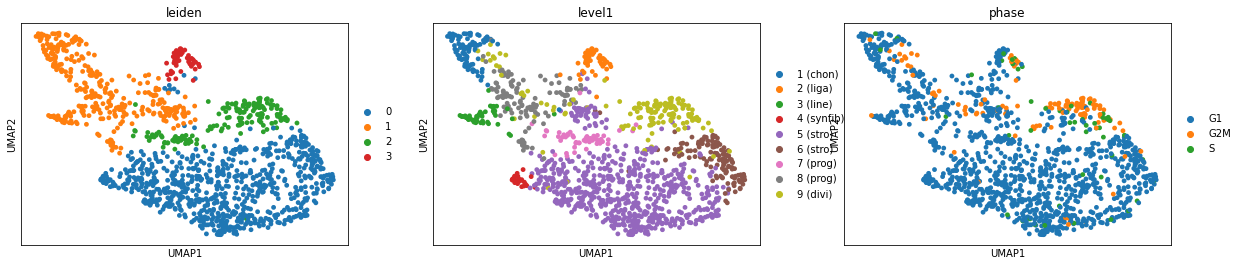

In [101]:
#Clustering
sc.tl.umap(adJoint, .25)
sc.tl.leiden(adJoint,.25)
sc.pl.umap(adJoint, color=["leiden", "level1","phase"])

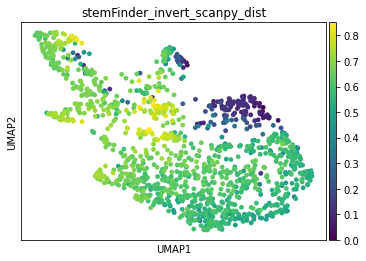

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


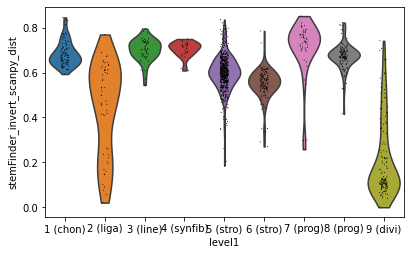

In [93]:
sc.pl.umap(adJoint, color=["stemFinder_invert_scanpy_dist"])
sc.pl.violin(adJoint, keys = 'stemFinder_invert_scanpy_dist', groupby = 'level1')

In [94]:
adJoint.write("adata_e17gle_011923.h5ad")

/Users/knoller/.pyenv/versions/3.7.4/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


# RNA velocity 

In [97]:
import scvelo as scv

Filtered out 2258 genes that are detected 20 counts (spliced).
Filtered out 3032 genes that are detected 20 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (ada

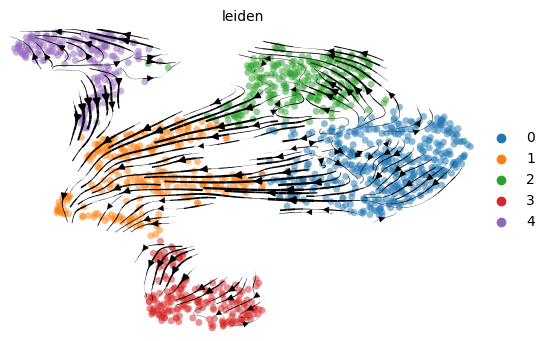

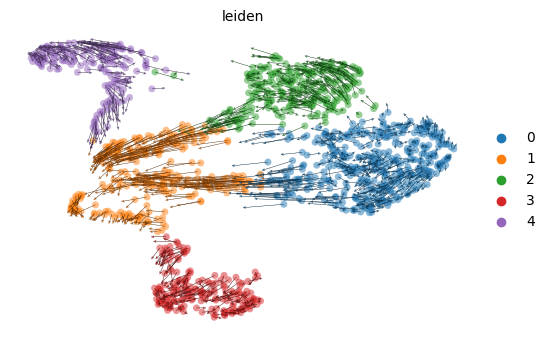

In [98]:
# Muscle lineage

adM = adata.copy()
adM.obs['leiden'] = adMyo.obs['leiden'].copy()
adM.uns['leiden_colors'] = adMyo.uns['leiden_colors'].copy()
adM = adM[  adMyo.obs_names,:]
adM = adM[:,  adMyo.var_names]
adM.obsm['X_umap'] = adMyo.obsm['X_umap'].copy()
adM.obsm['X_pca'] = adMyo.obsm['X_pca'].copy()

adsub = adM[adMyo.obs_names,:].copy() #subset raw QC'ed data for just these cells 

scv.pp.filter_and_normalize(adsub, min_counts=20, min_counts_u=20,n_top_genes=2000)
scv.pp.moments(adsub, n_pcs=npcs, n_neighbors=50)
scv.tl.velocity(adsub)
scv.tl.velocity_graph(adsub)
scv.tl.velocity_embedding(adsub, basis="pca")# direct_projection=False)
#scv.pl.velocity_embedding(adM, color=['leiden'],basis='pca', alpha=.5, size=100, scale=.20, legend_loc='on data', dpi=100)

scv.pl.velocity_embedding_stream(adsub, color=['leiden'],basis='umap',alpha=.5, size=100, dpi=100,legend_loc='right margin')
scv.pl.velocity_embedding(adsub, color=['leiden'],basis='umap', alpha=.5, size=100, scale=.20, legend_loc='right margin', dpi=100)

Filtered out 2362 genes that are detected 20 counts (spliced).
Filtered out 3714 genes that are detected 20 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (ada

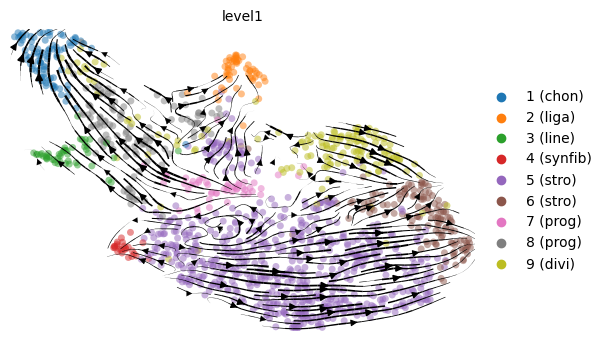

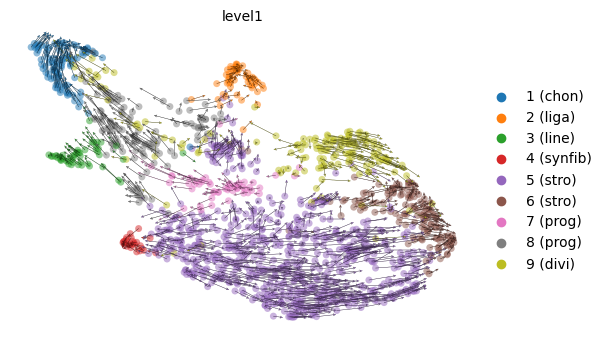

In [99]:
# E17 GLE lineage cells

adM = adata.copy()
adM.obs['level1'] = adJoint.obs['level1'].copy()
adM.uns['level1_colors'] = adJoint.uns['level1_colors'].copy()
adM = adM[  adJoint.obs_names,:]
adM = adM[:,  adJoint.var_names]
adM.obsm['X_umap'] = adJoint.obsm['X_umap'].copy()
adM.obsm['X_pca'] = adJoint.obsm['X_pca'].copy()

adsub = adM[adJoint.obs_names,:].copy() #subset raw QC'ed data for just these cells 

scv.pp.filter_and_normalize(adsub, min_counts=20, min_counts_u=20,n_top_genes=2000)
scv.pp.moments(adsub, n_pcs=npcs, n_neighbors=50)
scv.tl.velocity(adsub)
scv.tl.velocity_graph(adsub)
scv.tl.velocity_embedding(adsub, basis="pca")# direct_projection=False)
#scv.pl.velocity_embedding(adM, color=['leiden'],basis='pca', alpha=.5, size=100, scale=.20, legend_loc='on data', dpi=100)

scv.pl.velocity_embedding_stream(adsub, color=['level1'],basis='umap',alpha=.5, size=100, dpi=100,legend_loc='right margin')
scv.pl.velocity_embedding(adsub, color=['level1'],basis='umap', alpha=.5, size=100, scale=.20, legend_loc='right margin', dpi=100)

#### Misc unused code below

In [ ]:
#Increase resolution on cluster 3
sc.tl.leiden(adM1Norm,.1, restrict_to=["leiden",["3"]])

sc.pl.umap(adM1Norm, color=["leiden_R"], alpha=.9, s=25)# , legend_loc='on data', cmap='OrRd', ncols=4)
sc.pl.umap(adM1Norm, color = ["EPCAM","PTPRC","CD3D","CD3E","CD3G","ITGAM","ITGAX"])


    #Leukocytes: clusters 2, 4, 5, 7, and 3.2 

In [26]:
# Remove leukocytes 
    
cids1 = adM1Norm[adM1Norm.obs['leiden'] != "2" ,:].obs_names
cids2 = adM1Norm[adM1Norm.obs['leiden'] != "4" ,:].obs_names
cids3 = adM1Norm[adM1Norm.obs['leiden'] != "5" ,:].obs_names
cids4 = adM1Norm[adM1Norm.obs['leiden'] != "7" ,:].obs_names
cids5 = adM1Norm[adM1Norm.obs['leiden'] != "3,2" ,:].obs_names

cids = cids1.intersection(cids2.intersection(cids3.intersection(cids4.intersection(cids5))))

adSC = adata[cids,:].copy() #subset raw QC'ed data for just these cells (non-leukocytes)
adSC

AnnData object with n_obs × n_vars = 3592 × 36484
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'phase', 'S_score', 'G2M_score', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

... storing 'cell_type_leiden' as categorical


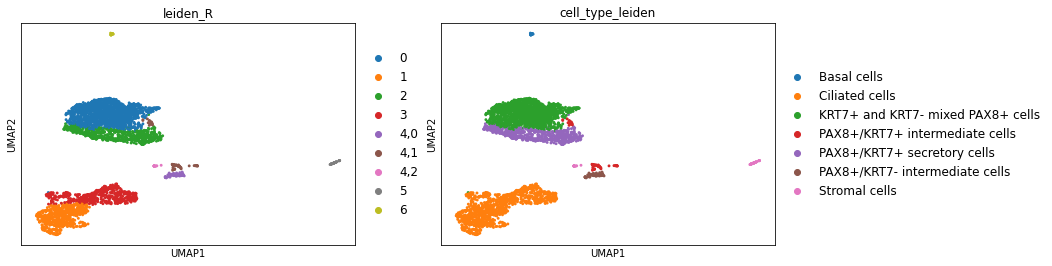

In [33]:
### Label and Plot Cells

new_cluster_names = {'0':'KRT7+ and KRT7- mixed PAX8+ cells','1':'Ciliated cells','2':'PAX8+/KRT7+ secretory cells','3':'Ciliated cells','4,0':'PAX8+/KRT7- intermediate cells','4,1':'PAX8+/KRT7+ intermediate cells','4,2':'Stromal cells','5':'Stromal cells','6':'Basal cells'}
adM1Norm.obs['cell_type_leiden']=adM1Norm.obs['leiden_R'].map(new_cluster_names)
sc.pl.umap(adM1Norm, color=['leiden_R','cell_type_leiden'],legend_fontsize=12)

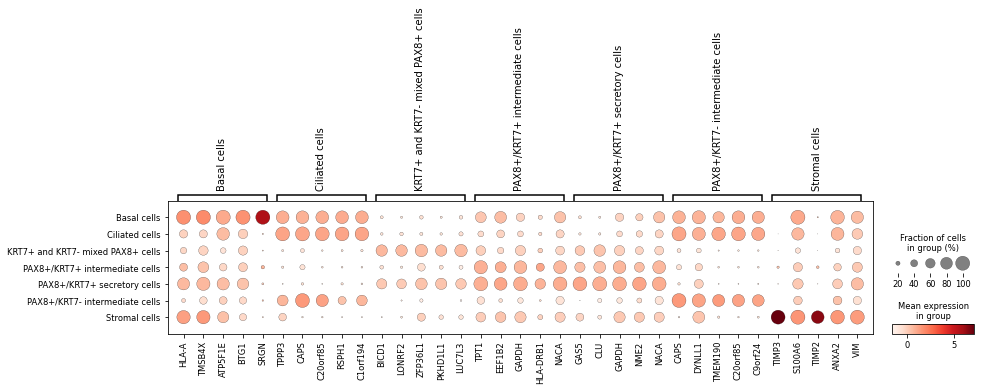

In [35]:
# Dot plot of top DE genes
sc.tl.rank_genes_groups(adM1Norm,'cell_type_leiden', n_genes=len(adM1Norm.var_names), use_raw=False)
sc.pl.rank_genes_groups_dotplot(adM1Norm, n_genes=5, groupby='cell_type_leiden', use_raw=False, dendrogram=False)

In [37]:
#Cell counts
adM1Norm.obs['cell_type_leiden'].value_counts()

KRT7+ and KRT7- mixed PAX8+ cells    1494
Ciliated cells                       1244
PAX8+/KRT7+ secretory cells           637
PAX8+/KRT7- intermediate cells         75
PAX8+/KRT7+ intermediate cells         64
Stromal cells                          54
Basal cells                            24
Name: cell_type_leiden, dtype: int64

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


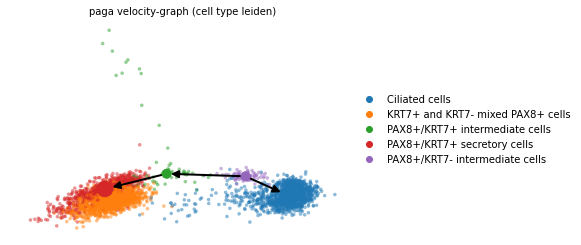

In [44]:
# Pseudotime and PAGA
scv.tl.velocity_pseudotime(adsub)
adsub.uns['neighbors']['distances'] = adsub.obsp['distances']
adsub.uns['neighbors']['connectivities'] = adsub.obsp['connectivities']
scv.tl.paga(adsub, groups='cell_type_leiden')
scv.pl.paga(adsub, basis='pca', size=50, alpha=.5,min_edge_width=2, node_size_scale=1.5, dashed_edges=None)